# Laboratorio 1

Alina Carias, Ariela Mishaan, Daniel Machic

## Librerías

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## TASK 2 - PRÁCTICA

### Ejercicio 1: Convolución 2D Genérica

In [6]:
def pad_reflect_manual (img, pad_h, pad_w):

    if pad_h == 0 and pad_w == 0:
        return img.copy()

    H, W = img.shape
    out = np.empty((H + 2*pad_h, W + 2*pad_w), dtype=img.dtype)

    out[pad_h:pad_h+H, pad_w:pad_w+W] = img

    if pad_h > 0:
        out[:pad_h, pad_w:pad_w+W] = img[pad_h:0:-1, :]
        out[pad_h+H:, pad_w:pad_w+W] = img[-2:-2-pad_h:-1, :]

    if pad_w > 0:
        out[:, :pad_w] = out[:, 2*pad_w:pad_w:-1]
        out[:, pad_w+W:] = out[:, pad_w+W-2:pad_w+W-2-pad_w:-1]

    return out

In [7]:
def mi_convolucion(imagen, kernel, padding_type='reflect'):
    if imagen.ndim != 2:
        raise ValueError("Solo en escala de grises (H,W).")

    img = imagen.astype(np.float32, copy=False)
    k = np.array(kernel, dtype=np.float32)

    if k.ndim != 2:
        raise ValueError("El kernel debe ser 2D.")
    if k.shape[0] % 2 == 0 or k.shape[1] % 2 == 0:
        raise ValueError("El kernel debe ser impar (3x3, 5x5...).")

    kh, kw = k.shape
    pad_h, pad_w = kh // 2, kw // 2

    # Convolución real: flip del kernel
    k = np.flipud(np.fliplr(k))

    if padding_type == 'reflect':
        padded = pad_reflect_manual(img, pad_h, pad_w)
    else:
        raise ValueError("Se debe de utilizar reflect como padding_type.")

    H, W = img.shape
    out = np.zeros((H, W), dtype=np.float32)

    for y in range(kh):
        for x in range(kw):
            out += k[y, x] * padded[y:y+H, x:x+W]

    return out

### Ejercicio 2: Generador de Gaussianos

In [8]:
def generar_gaussiano(tamanio, sigma, mu=0.0):
    tamanio = int(tamanio)
    sigma = float(sigma)
    mu = float(mu)

    if tamanio <= 0 or tamanio % 2 == 0:
        raise ValueError("el tamanio debe ser impar y > 0.")
    if sigma <= 0:
        raise ValueError("sigma debe ser > 0.")

    r = tamanio // 2
    y, x = np.mgrid[-r:r+1, -r:r+1].astype(np.float32)

    g = np.exp(-(((x - mu)**2 + (y - mu)**2) / (2.0 * sigma * sigma)))

    g /= g.sum()

    return g.astype(np.float32)


(Whyamit404, 2025)

### Ejercicio 3: Pipeline de Detección de bordes (Sobel)

In [9]:
def detectar_bordes_sobel(imagen, suavizar=True, tamano_gauss=5, sigma=1.2):
    if imagen.ndim != 2:
        raise ValueError("Solo grayscale (H,W).")

    img = imagen.astype(np.float32, copy=False)
    if suavizar:
        kG = generar_gaussiano(tamano_gauss, sigma)
        img = mi_convolucion(img, kG, padding_type='reflect')

    filtro = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]], dtype=np.float32)

    gx = mi_convolucion(img, filtro, padding_type='reflect')

    filtro_y = np.flip(filtro.T, axis=0)
    gy = mi_convolucion(img, filtro_y, padding_type='reflect')

    mag = np.sqrt(np.square(gx) + np.square(gy)).astype(np.float32)

    mmax = mag.max()
    if mmax > 0:
        mag_u8 = (mag * (255.0 / mmax)).clip(0, 255).astype(np.uint8)
    else:
        mag_u8 = np.zeros_like(imagen, dtype=np.uint8)

    theta = np.arctan2(gy, gx).astype(np.float32)

    return mag_u8, theta, gx, gy

(Jana, 2019)

## Prueba

In [10]:
def pipeline_suavizar_y_sobel(imagen, tamanio=5, sigma=1.2):
    # Kernel gaussiano
    k = generar_gaussiano(tamanio, sigma)

    # Suavizado con la convolución
    suav = mi_convolucion(imagen, k, padding_type="reflect")

    # Mantener rango válido para visualizar/guardar
    suav_u8 = np.clip(suav, 0, 255).astype(np.uint8)

    # Sobel
    mag_u8, theta, gx, gy = detectar_bordes_sobel(suav_u8, suavizar=False)

    return suav_u8, mag_u8, theta


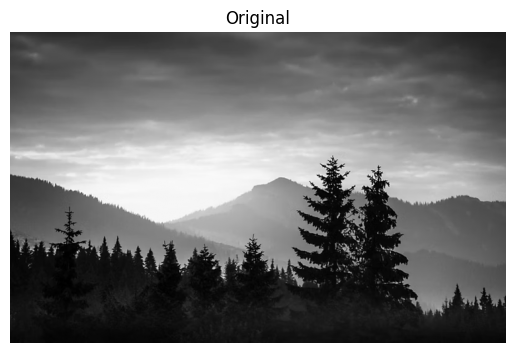

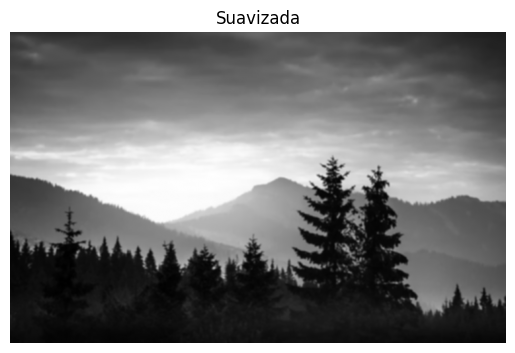

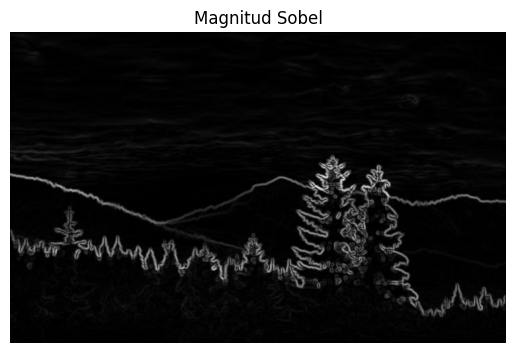

In [11]:
img = cv2.imread("grises.png", cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError("No se puede leer grises.png. Revisar el nombre y la ruta.")

suav, mag, theta = pipeline_suavizar_y_sobel(img, tamanio=5, sigma=1.2)

plt.figure(); plt.title("Original"); plt.imshow(img, cmap="gray"); plt.axis("off")
plt.figure(); plt.title("Suavizada"); plt.imshow(suav, cmap="gray"); plt.axis("off")
plt.figure(); plt.title("Magnitud Sobel"); plt.imshow(mag, cmap="gray"); plt.axis("off")
plt.show()

## Referencias

Jana, A. (2019, 18 mayo). How to implement Sobel edge detection using Python from scratch. A Developer Diary. https://adeveloperdiary.com/data-science/computer-vision/how-to-implement-sobel-edge-detection-using-python-from-scratch/ 

Whyamit404. (2025, 2 febrero). Creating a Gaussian Distribution with NumPy. Medium. https://medium.com/@whyamit404/creating-a-gaussian-distribution-with-numpy-dc810d931ee0 

## Task 3 – Evaluación de Ingeniería y Criterio

(np.float64(-0.5), np.float64(599.5), np.float64(399.5), np.float64(-0.5))

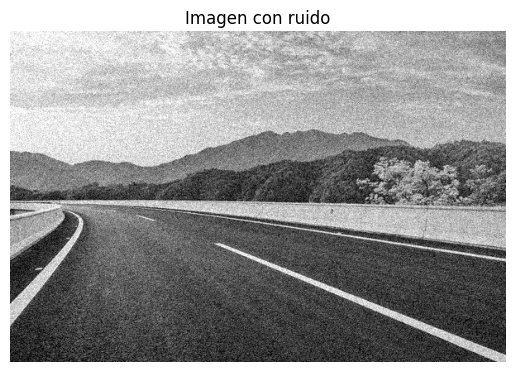

In [23]:
# Cargar imagen
img = cv2.imread("carretera.png")

# Convertir a escala de grises
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Imagen con Ruido
def agregar_ruido_gaussiano(imagen, mean=0, std=20):
    ruido = np.random.normal(mean, std, imagen.shape)
    imagen_ruido = imagen + ruido
    return np.clip(imagen_ruido, 0, 255)

img_ruido = agregar_ruido_gaussiano(img_gray)

plt.imshow(img_ruido, cmap='gray')
plt.title("Imagen con ruido")
plt.axis("off")

### Experimento A: El efecto de Sigma

(np.float64(-0.5), np.float64(599.5), np.float64(399.5), np.float64(-0.5))

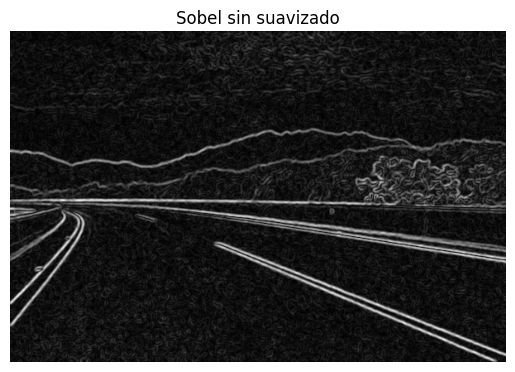

In [31]:
# Sin Suavizado
G_sin = detectar_bordes_sobel(img_ruido)[0]

plt.imshow(G_sin, cmap='gray')
plt.title("Sobel sin suavizado")
plt.axis("off")

(np.float64(-0.5), np.float64(599.5), np.float64(399.5), np.float64(-0.5))

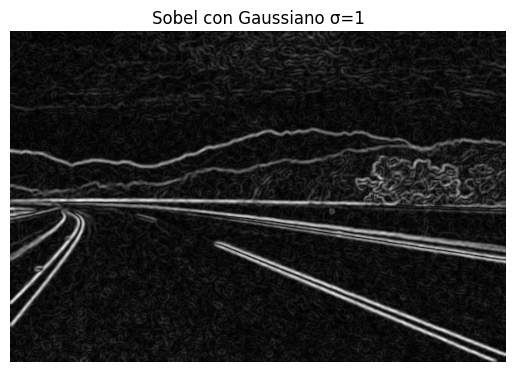

In [32]:
# Gaussiano σ = 1 (5x5)
kernel_g1 = generar_gaussiano(5, sigma=1)
img_suave_1 = mi_convolucion(img_ruido, kernel_g1)
G_sigma1 = detectar_bordes_sobel(img_suave_1)[0]

plt.imshow(G_sigma1, cmap='gray')
plt.title("Sobel con Gaussiano σ=1")
plt.axis("off")

(np.float64(-0.5), np.float64(599.5), np.float64(399.5), np.float64(-0.5))

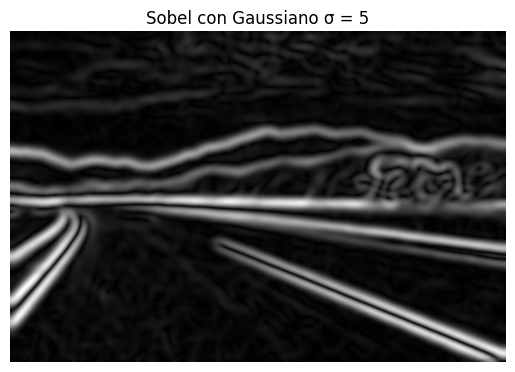

In [ ]:
# Gaussiano σ = 5 (31x31)
kernel_g5 = generar_gaussiano(31, sigma=5)
img_suave_5 = mi_convolucion(img_ruido, kernel_g5)
G_sigma5 = detectar_bordes_sobel(img_suave_5)[0]

plt.imshow(G_sigma5, cmap='gray')
plt.title("Sobel con Gaussiano σ = 5")
plt.axis("off")

### Análisis
Al analizar las tres imágenes de bordes obtenidas, se observa que cuando no se aplica suavizado previo, el operador Sobel detecta fuertemente la textura del suelo y el ruido presente en la imagen, generando numerosos falsos bordes que podrían ser interpretados erróneamente como obstáculos. En contraste, al utilizar un suavizado Gaussiano con un valor de σ alto, los bordes finos y detalles pequeños como grietas del suelo se atenúan o desaparecen debido a la eliminación de altas frecuencias, permaneciendo únicamente los bordes asociados a estructuras grandes. Desde un punto de vista de ingeniería, el uso de un Gaussiano con σ elevado resulta la mejor opción para detectar pallets grandes en un entorno industrial, ya que reduce significativamente el ruido y la textura del suelo, mejorando la robustez del sistema de detección y evitando falsas detecciones que afectarían la navegación del robot.

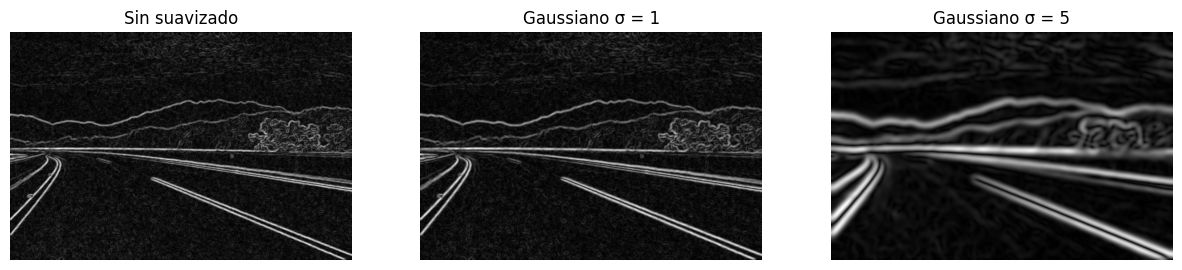

In [36]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(G_sin, cmap='gray')
plt.title("Sin suavizado")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(G_sigma1, cmap='gray')
plt.title("Gaussiano σ = 1")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(G_sigma5, cmap='gray')
plt.title("Gaussiano σ = 5")
plt.axis("off")

plt.show()

### Experimento B: Histéresis Manual (Simulación de Canny)

In [37]:
def umbral_simple(magnitud, T):
    salida = np.zeros_like(magnitud)
    salida[magnitud >= T] = 255
    return salida

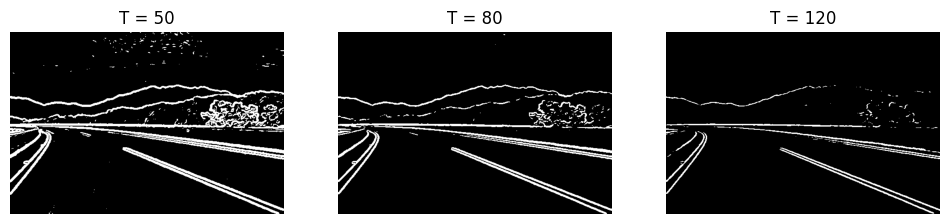

In [45]:
# Probar un valor de umbral T único
Ts = [50, 80, 120]

plt.figure(figsize=(12,4))

for i, T in enumerate(Ts):
    plt.subplot(1, 3, i+1)
    plt.imshow(umbral_simple(G_sigma1, T), cmap='gray')
    plt.title(f"T = {T}")
    plt.axis("off")

plt.show()

Al aplicar un umbral simple a la magnitud del gradiente, se observa que las líneas de los bordes tienden a romperse, especialmente en zonas donde la intensidad del gradiente disminuye ligeramente. Esto ocurre porque un único valor de umbral no puede adaptarse a las variaciones locales de iluminación y contraste a lo largo de un mismo borde, provocando discontinuidades visibles. Como resultado, los bordes pierden continuidad, lo que dificulta la correcta identificación de objetos completos en la imagen.

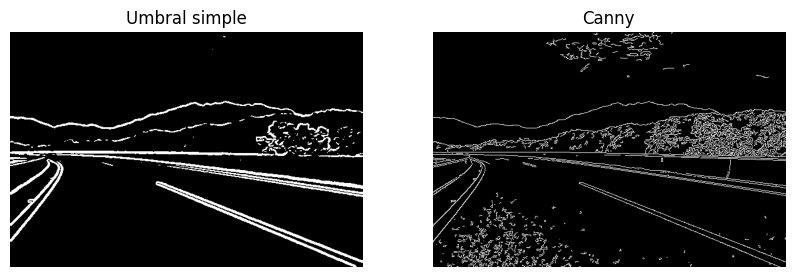

In [ ]:
# Simulación de Canny
canny = cv2.Canny(img_gray, 100, 200)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(bordes_umbral, cmap='gray')
plt.title("Umbral simple")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(canny, cmap='gray')
plt.title("Canny")
plt.axis("off")

plt.show()

Un umbral de corte simple nunca alcanza la efectividad del método de histéresis utilizado en el algoritmo de Canny porque emplea un único valor de decisión que no considera la continuidad ni la estructura de los bordes. En escenarios reales, como un robot en movimiento, las vibraciones y los cambios leves de iluminación provocan variaciones locales en la magnitud del gradiente a lo largo de un mismo borde, haciendo que algunas secciones caigan por debajo del umbral y se pierdan. La histéresis resuelve este problema al utilizar dos umbrales y un criterio de conectividad, permitiendo que los bordes débiles se conserven únicamente si están conectados a bordes fuertes, lo que garantiza continuidad espacial y una detección de obstáculos más robusta y estable durante la navegación del robot.
